In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
# Imports
import pickle 
import sys
import os
from os import listdir
from os.path import isfile, join
import numpy as np
#import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf 
from tensorflow import keras as k

#import cv2
from PIL import Image

# Import and Reshape Data Given

In [7]:
path = "/content/drive/My Drive/COMP_551_Machine_Learning/Miniproject2/data"


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'test_batch']
raw_export = []
data_raw = []
meta = unpickle(path + "/batches.meta")
label_names = [f.decode('ASCII') for f in meta[b'label_names']]
num_cases_per_batch = meta[b'num_cases_per_batch']

for f in files:
  pick = unpickle(f"{path}/{f}")
  raw_export = np.append(raw_export, pick)  
  data_raw.append(pick[b'data'])


**Raw Data Layout**

data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image. 

labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. 


In [9]:
# Convert raw data to list of RGB pixel values
# input: raw data array
def get_rgb_data(x):
  pixel_list = []
  
  for i in range(0, int(np.shape(x)[0]/3)):
    pixel_list.append(np.squeeze(np.dstack((x[3*i:(3*(i+1))]))))

  return pixel_list

# Convert rgb data to list of greyscale pixel values
# input: rgb pixel data array
def get_grayscale_data(y):
  grey_pixel_list = []

  for i in range(np.shape(y)[0]):
    temp = np.sum(y[i] * [0.2989, 0.5870, 0.1140], axis=1).astype(int)
    grey_pixel_list.append(temp)
  return grey_pixel_list

# RGB 2D array output (32 x 32 image)
def rgb_2D_picture(x):
  return np.reshape(x, (32, 32, 3))

# Greyscale  2D array output (32 x 32 image)
def greyscale_2D_picture(x):
    return np.reshape(x, (32, 32))

In [10]:
data_pixel = []
for i in range(6):
  data_pixel.append(get_rgb_data(np.reshape(data_raw[i], (30000, 1024))))

data_greyscale = []
for i in range(6):
  data_greyscale.append(get_grayscale_data(data_pixel[i]))


In [11]:
trainX = []
testX = data_greyscale[5]
trainX = np.reshape(np.stack(data_greyscale[:5]), (50000, 1024))

y = []
for i in range(5):
  y.append(np.array(raw_export[i][b'labels']))

trainY = np.reshape(y, (50000, ))
testY = np.array(raw_export[5][b'labels'])

print(np.shape(trainX))
print(np.shape(trainY))
print(np.shape(testX))
print(np.shape(testY))

(50000, 1024)
(50000,)
(10000, 1024)
(10000,)


In [12]:
trainX_RGB = []
testX_RGB = data_pixel[5]
trainX_RGB = np.reshape(np.stack(data_pixel[:5]), (50000, 1024, 3))

print(np.shape(trainX_RGB))
print(np.shape(trainY))
print(np.shape(testX_RGB))
print(np.shape(testY))

(50000, 1024, 3)
(50000,)
(10000, 1024, 3)
(10000,)


In [13]:
distribution = []
print("Class Distribution \n")

for i in range(6):
  print("Class "  + label_names[i] + ": " + str(np.sum(trainY == i) + np.sum(testY == i)))

Class Distribution 

Class airplane: 6000
Class automobile: 6000
Class bird: 6000
Class cat: 6000
Class deer: 6000
Class dog: 6000


#### Train Images

## Check Images

In [ ]:
def get_label(x):
  return label_names[x]

def plot_image_set(i):
  image1 = rgb_2D_picture(trainX_RGB[i])
  image2 = greyscale_2D_picture(trainX[i])

  plt.subplot(1, 2, 1)
  plt.imshow((image1).astype(np.uint8))
  plt.title("Original Image \n label: " + get_label(trainY[i]))

  plt.subplot(1, 2, 2)
  plt.gray()
  plt.imshow(image2)
  plt.title("Greyscale Image \n label: " + get_label(trainY[i]))
  plt.show()

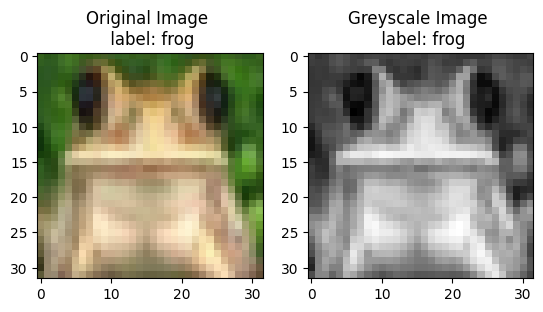

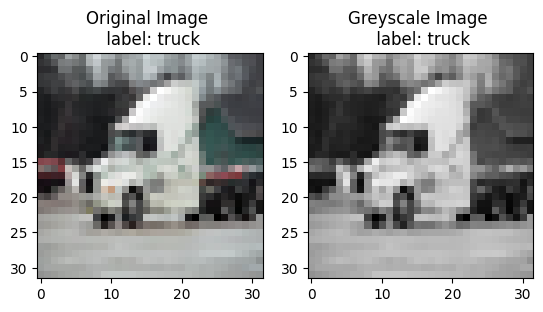

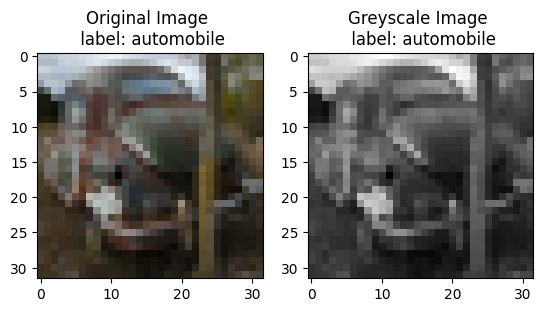

In [ ]:
plot_image_set(22345)
plot_image_set(np.random.randint(0, 50000))
plot_image_set(np.random.randint(0, 50000))

#### Test Images

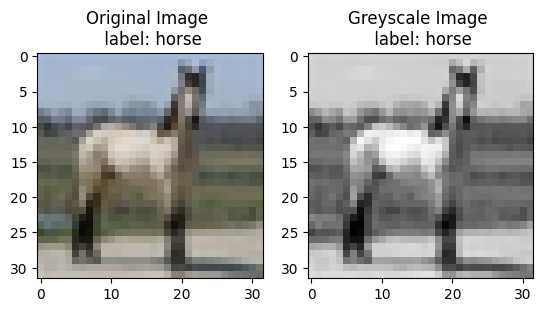

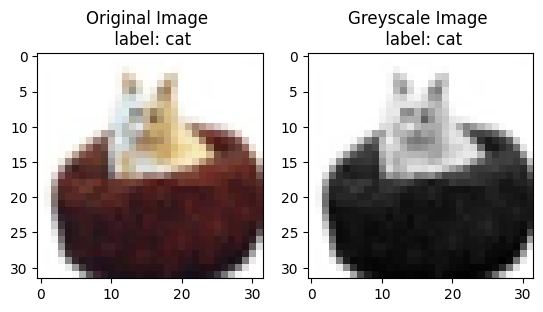

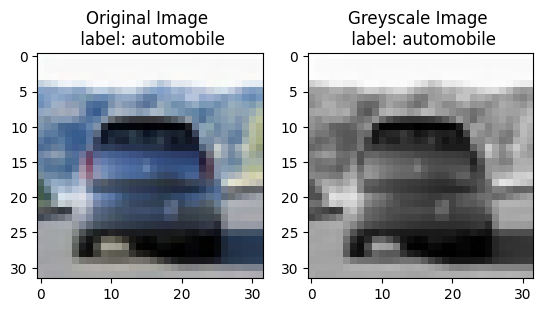

In [ ]:
plot_image_set(789)
plot_image_set(np.random.randint(0, 10000))
plot_image_set(np.random.randint(0, 10000))

#Preprocessing

### Mean & Normalization
*  Faster convergence.
*  Decreases the importance of initial weights.
*  Robust to hyperparameters.
*  Requires less data for generalization.

#### Batch Normalization 
"For any hidden layer h, we pass the inputs through a non-linear activation to get the output. For every neuron (activation) in a particular layer, we can force the pre-activations to have zero mean and unit standard deviation. This can be achieved by **subtracting the mean from each of the input features across the mini-batch and dividing by the standard deviation.**"
https://www.pinecone.io/learn/batch-layer-normalization/


In [14]:
def preprocess(trainx, testx, normalize=True, subtract_pixel_mean=True):
  trainx_preprocessed = trainx
  testx_preprocessed = testx
  
  if subtract_pixel_mean:
      mean = np.mean(trainx)
      trainx_preprocessed = trainx - mean
      testx_preprocessed = testx - mean
  
  if normalize:
    trainx_preprocessed = (trainx - np.min(trainx)) / (np.max(trainx) - np.min(trainx))
    trainx_preprocessed  = 2 * trainx_preprocessed - 1

    testx_preprocessed = (testx - np.min(trainX)) / (np.max(trainx) - np.min(trainx))
    testx_preprocessed  = 2 * testx_preprocessed - 1

  return trainx_preprocessed, testx_preprocessed

In [15]:
trainX_processed, testX_processed = preprocess(trainX, testX)
trainX_RGB_processed, testX_RGB_processed = preprocess(trainX_RGB, testX_RGB)

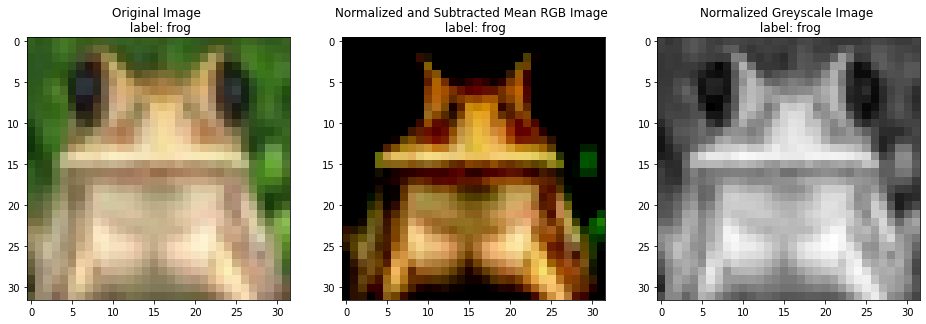

In [16]:
def get_label(x):
  return label_names[x] 
# https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258
# above link shows normalized images of faces


trainX_processed, testX_processed = preprocess(trainX, testX)
trainX_RGB_processed, testX_RGB_processed = preprocess(trainX_RGB, testX, normalize=True, subtract_pixel_mean=True)

i = 22345
imageO = rgb_2D_picture(trainX_RGB[i])
image2 = greyscale_2D_picture(trainX_processed[i])
image1 = rgb_2D_picture(trainX_RGB_processed[i])

plt.figure(figsize=(16,16))
plt.subplot(1, 3, 1)
plt.imshow(imageO)
plt.title("Original Image \n label: " + get_label(trainY[i]))

plt.subplot(1, 3, 2)
plt.gray()
plt.imshow(image1)
plt.title("Normalized and Subtracted Mean RGB Image \n label: " + get_label(trainY[i]))


plt.subplot(1, 3, 3)
plt.gray()
plt.imshow(image2)
plt.title("Normalized Greyscale Image \n label: " + get_label(trainY[i]))

plt.show()

Functions

In [17]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def ReLU_derivative(Z):
    return Z > 0

def one_hot_encoding(value):
   array = np.zeros(np.shape(label_names))
   array[value] = 1;
   return array

def tanh(df):
  return np.tanh(df)

def leaky_relu(df, alpha=0.01):
  leaky_relu_df = np.maximum(df, 0) + alpha*np.minimum(0, df)
  return leaky_relu_df


def leaky_relu_derivative(x, alpha=0.01): #Derivative of a ReLU is 0 for x < 0 and 1 for x > 0. For leaky ReLU, the derivative is the alpha for x < 0.
  return np.where(x > 0, 1, alpha);

def sigmoid(x):
    return 1/(1+np.exp(-1*x))

def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def pred_class(x, axis=0):
  return np.argmax(x, axis=axis)

MLP Class

In [18]:
from tqdm import tqdm
class LinearLayer():
    def __init__(self,x_size, y_size, reg=None, reg_strength=0.01, norm=False):
        if(norm):
            self.w = np.random.normal(0 , 0.0001, size = (y_size, x_size)) #Not normalizedThe
            self.b = np.random.normal(0 , 0.0001, size = (y_size,1))
        else:
            self.w = np.random.normal(0 , 0.0825, size = (y_size, x_size)) #Normalized
            self.b = np.random.normal(0 , 0.0825, size = (y_size,1))
        self.dw = None
        self.db = None
        self.reg = reg
        self.reg_strength = reg_strength
        self.input = None    

    def forward(self, x):
        self.input = x
        return (self.w @ x.T + self.b).T

    def backward(self, gradient):
        self.dw = (self.input.T @ gradient).T 
        self.db = np.sum(gradient)
        
        # Regularization
        if self.reg == "L1":
            self.dw += self.reg_strength * np.abs(self.w)
        elif self.reg == "L2":
            self.dw += self.reg_strength * np.square(self.w)
        
        return gradient.dot(self.w)

        
class ReLULayer():
    def __init__(self):
        self.gradient = None

    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return  np.maximum(0, x)

    def backward(self, gradient):
        return gradient * self.gradient
    

class LeakyReLULayer():
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.gradient = None

    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, self.alpha)
        return  np.where(x > 0, x, x * self.alpha)

    def backward(self, gradient):
        return gradient * self.gradient
    
class TanHLayer():
    def __init__(self):
        self.gradient = None

    def forward(self, x):
        self.gradient = 1 - np.tanh(x)**2
        return np.tanh(x) # Was "df".

    def backward(self, gradient):
        return gradient * self.gradient
    
    
class SoftmaxLayer():
    def __init__(self):
        self.probabilities = None

    def forward(self, x):
        exps = np.exp(x)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.probabilities = probs
        return probs

    def backward(self, target):
        return self.probabilities - target #Self.probabilities goes from shape of (250,10) to (50000,10)
    

def activation_func(f):
        if f == "Relu":
            return ReLULayer()
        elif f == "LeakyReLU":
            return LeakyReLULayer()
        elif f == "Tanh":
            return TanHLayer()
        
class MLP:
    def __init__(self, functions, layer_units, learning_rate, reg=None, reg_strength=0.01, norm=False):
    
        self.layers = []
        self.learning_rate = learning_rate
        if len(layer_units) != 0:
            self.layers.append(LinearLayer(1024, layer_units[0],reg, reg_strength, norm))
            self.layers.append(activation_func(functions[0]))
            for i in range(0,len(layer_units)-1):
                self.layers.append(LinearLayer(layer_units[i], layer_units[i+1],reg, reg_strength, norm))
                self.layers.append(activation_func(functions[i+1]))
            self.layers.append(LinearLayer(layer_units[-1], 10 ,reg, reg_strength, norm))
            self.layers.append(SoftmaxLayer())
        else: 
            self.layers.append(LinearLayer(1024, 10 ,reg, reg_strength, norm))
            self.layers.append(SoftmaxLayer())
        self.loss_array = []
        self.accuracy_array = []
        self.accuracy_array_test = []

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

 
    def fit(self, data_x, data_y, iterations, test_x, test_y):
        labels = np.eye(10)[np.array(data_y)]
        x = np.split(data_x, 200)
        y = np.split(labels, 200)
        n = 0
        opt = GradientDescentOptimizer(self)
        for i in tqdm(range(iterations)):
            predictions = self.forward(x[n])
            loss = -(y[n] * np.log(predictions)).sum(axis=-1).mean()
            self.loss_array.append(loss)
            self.backward(y[n])
            opt.update()
            if(i+1) % 50 == 0:
                #Accuracy for train
                predictions = self.predict(data_x)
                accuracy = np.sum(predictions == data_y) / data_y.size * 100
                #print(accuracy)
                self.accuracy_array.append(accuracy)

                #Accuracy for test
                predictionsT = self.predict(test_x)
                accuracyT = np.sum(predictionsT == test_y) / test_y.size * 100
                #print(accuracyT)
                self.accuracy_array_test.append(accuracyT)
            n=n+1
            if n == 200:
                n = 0
        
    def predict(self,data_x):
        predictions = self.forward(data_x)
        return np.argmax(predictions, axis = 1)

        
class GradientDescentOptimizer:
    def __init__(self, mlp):
        self.mlp = mlp
        
    def update(self):
        for i in range(len(self.mlp.layers)-2,-1,-2):    
            self.mlp.layers[i].b -= self.mlp.learning_rate * self.mlp.layers[i].db          
            self.mlp.layers[i].w -= self.mlp.learning_rate * self.mlp.layers[i].dw

Task 3-1: Create three different models: (1) an MLP with no hidden layers, i.e., it directly maps the inputs
to outputs, (2) an MLP with a single hidden layer having 256 units and ReLU activations, (3) an MLP with 2
hidden layers each having 256 units with ReLU activations. It should be noted that since we want to perform
classification, all of these models should have a softmax layer at the end. Train and test the accuracy of the models.

In [ ]:
NoHiddenModel = MLP([], [], 0.0001)
NoHiddenModel.fit(trainX_processed, trainY, 10000, testX_processed, testY) # We pass in test values to keep track of changing accuracy

100%|██████████| 10000/10000 [00:33<00:00, 300.01it/s]


LOSS


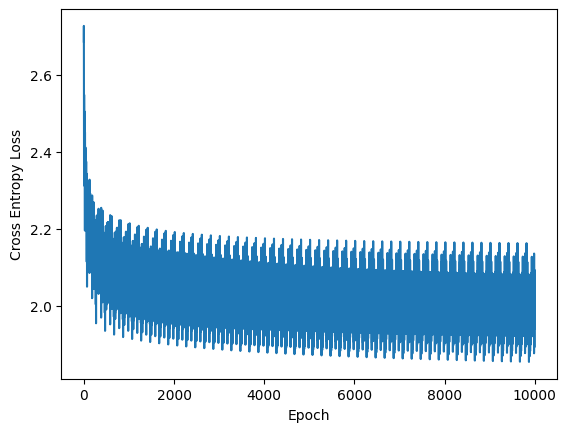

Final train accuracy:  31.391999999999996 %
Final test accuracy:  28.7 %


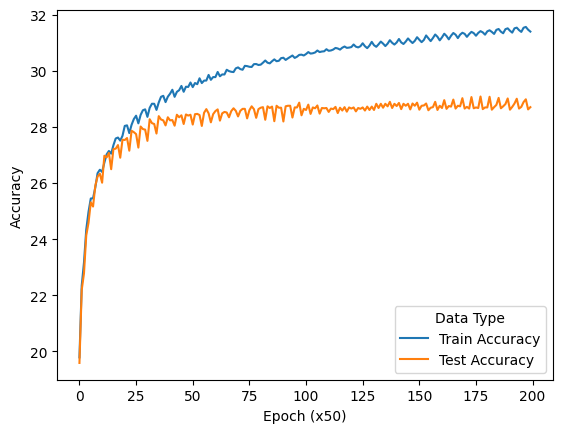

In [ ]:
def plotLossAndAcc(model, accInterval="50"):
    #Plot loss and accuracy
    print("LOSS");
    plt.plot(model.loss_array)
    plt.xlabel("Epoch")
    plt.ylabel("Cross Entropy Loss")
    plt.show()

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the lines and add labels
    ax.plot(model.accuracy_array, label="Train Accuracy")
    ax.plot(model.accuracy_array_test, label="Test Accuracy")
    # Add legend, x label and y label
    ax.legend(loc="lower right", title="Data Type")
    ax.set_xlabel("Epoch (x" + accInterval + ")")
    ax.set_ylabel("Accuracy")

    plt.show

    print("Final train accuracy: ", model.accuracy_array[-1], "%")
    print("Final test accuracy: ", model.accuracy_array_test[-1], "%")


plotLossAndAcc(NoHiddenModel)

In [ ]:
OneHiddenModel = MLP(["Relu"],[256], 0.0001)
OneHiddenModel.fit(trainX_processed, trainY, 10000, testX_processed, testY)

100%|██████████| 10000/10000 [02:53<00:00, 57.52it/s]


LOSS


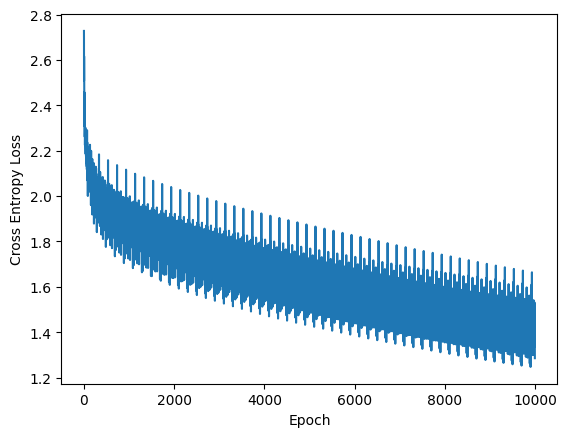

Final train accuracy:  51.222 %
Final test accuracy:  41.6 %


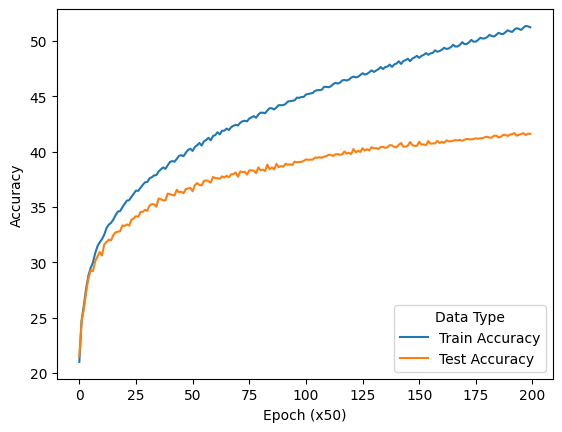

In [ ]:
plotLossAndAcc(OneHiddenModel)

In [ ]:
TwoHiddenModel = MLP(["Relu", "Relu"], [256, 256], 0.0001) #LR 0.0005 has 84.12-41.26
TwoHiddenModel.fit(trainX_processed, trainY, 10000, testX_processed, testY) 

100%|██████████| 10000/10000 [04:11<00:00, 39.82it/s]


LOSS


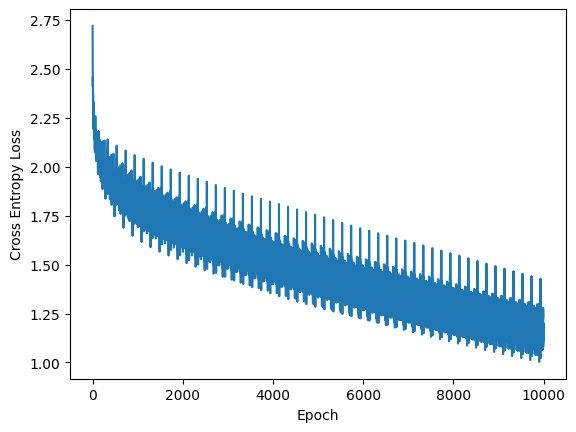

Final train accuracy:  60.26200000000001 %
Final test accuracy:  42.870000000000005 %


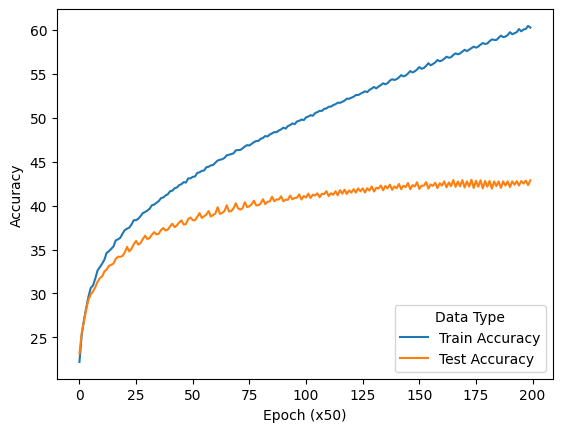

In [ ]:
#Plot loss and accuracy
plotLossAndAcc(TwoHiddenModel)

In [ ]:
TwoHiddenModel0_0005 = MLP(["Relu", "Relu"], [256, 256], 0.0005) #LR 0.0005 has 84.12-41.26
TwoHiddenModel0_0005.fit(trainX_processed, trainY, 10000, testX_processed, testY) 

100%|██████████| 10000/10000 [04:03<00:00, 41.06it/s]


In [ ]:
TwoHiddenModel0_00005 = MLP(["Relu", "Relu"], [256, 256], 0.00005) 
TwoHiddenModel0_00005.fit(trainX_processed, trainY, 10000, testX_processed, testY) 

100%|██████████| 10000/10000 [04:01<00:00, 41.34it/s]


Task 3-2: Take the last model above, the one with 2 hidden layers, and create two different copies of it in which the
activations are now tanh and Leaky-ReLU. After training these two models compare their test accuracies with
model having ReLU activations.

In [ ]:
#Define the LeakyReLU model and train.
LeakyModel = MLP(["LeakyReLU", "LeakyReLU"], [256, 256], 0.0001) #LR 0.0001 has 59.28-42.44 LR, 0.0005 has 81.234-38.7
LeakyModel.fit(trainX_processed, trainY, 10000, testX_processed, testY) 

100%|██████████| 10000/10000 [03:59<00:00, 41.69it/s]


LOSS


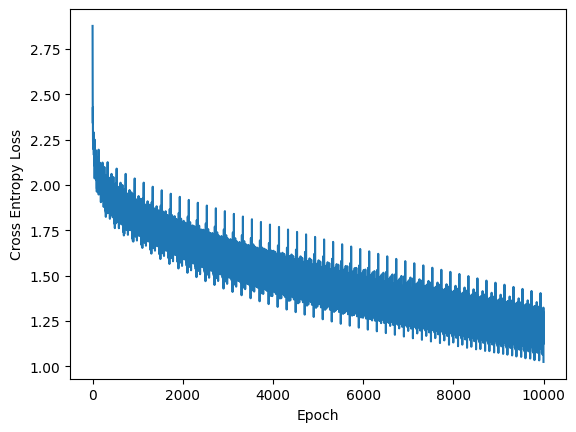

Final train accuracy:  59.565999999999995 %
Final test accuracy:  43.3 %


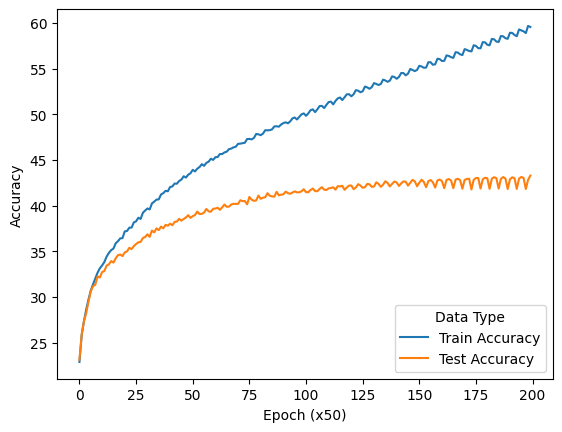

In [ ]:
#Print results for Leaky model.
plotLossAndAcc(LeakyModel)

In [ ]:
#Define the Tanh model and train.   
TanhModel = MLP(["Tanh", "Tanh"], [256, 256], 0.0001 ) #LR 0.0001 had acc 54.38-42.77. LR 0.0005 had acc 80.3%-38.18%
TanhModel.fit(trainX_processed, trainY, 10000, testX_processed, testY) 

100%|██████████| 10000/10000 [06:52<00:00, 24.27it/s]


LOSS


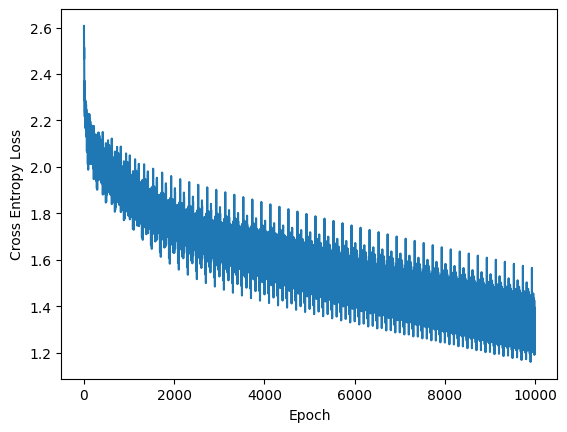

Final train accuracy:  54.867999999999995 %
Final test accuracy:  42.91 %


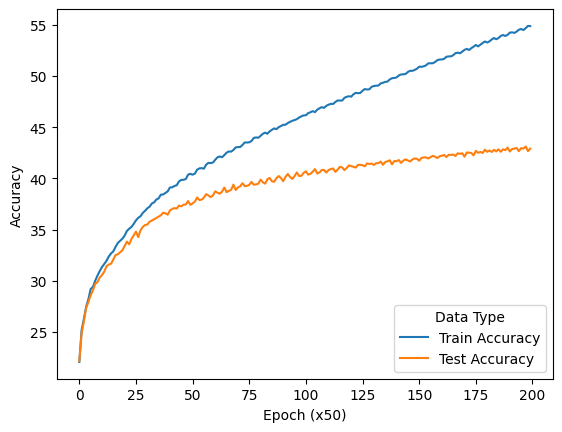

In [ ]:
#Print results for the Tanh model.
plotLossAndAcc(TanhModel)

Task 3-3: Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this
time, independently add L1 and L2 regularization to the network and train the MLP in this way. How does
these regularizations affect the accuracy? This proportion can be varied as a tunable hyperparameter that can be
explored as part of other project requirements.

In [ ]:
#Define and train the L1 Model.
L1Model = MLP(["Relu", "Relu"], [256, 256], 0.0001, "L1", 0.9) #RegStr 0.01, LR 0.0001  had 60-43.75% 0.05 had 59.7-42.66
L1Model.fit(trainX_processed, trainY, 10000, testX_processed, testY) 

100%|██████████| 10000/10000 [04:36<00:00, 36.15it/s]


LOSS


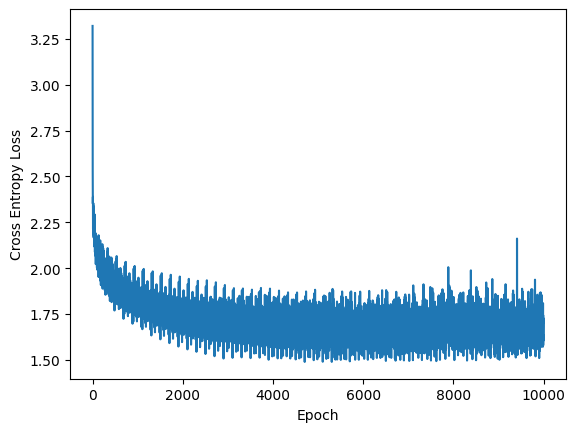

Final train accuracy:  40.942 %
Final test accuracy:  36.86 %


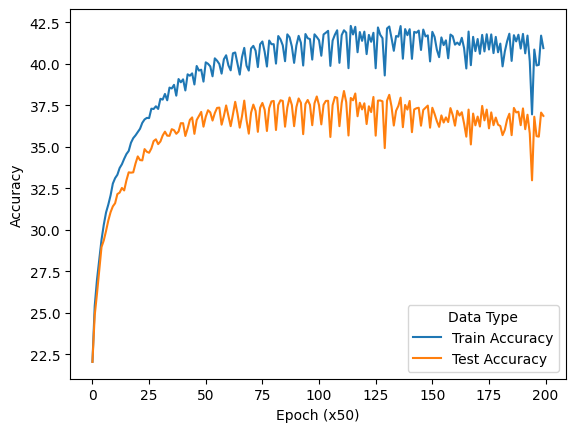

In [ ]:
#Print results for the L1 Model.
plotLossAndAcc(L1Model)

In [ ]:
#Define and train the L2 model.
L2Model = MLP(["Relu", "Relu"], [256, 256], 0.0001, "L2", 0.9) #RegStr 0.01, LR 0.0001 had  59.56-41.93, 0.05 had 59.99-42.77
L2Model.fit(trainX_processed, trainY, 10000, testX_processed, testY) 

100%|██████████| 10000/10000 [04:41<00:00, 35.56it/s]


LOSS


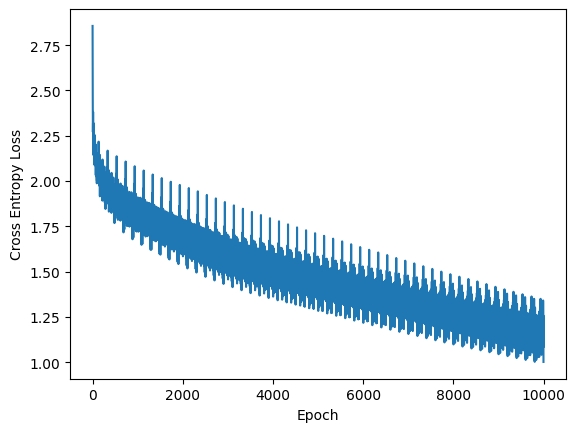

Final train accuracy:  60.118 %
Final test accuracy:  43.02 %


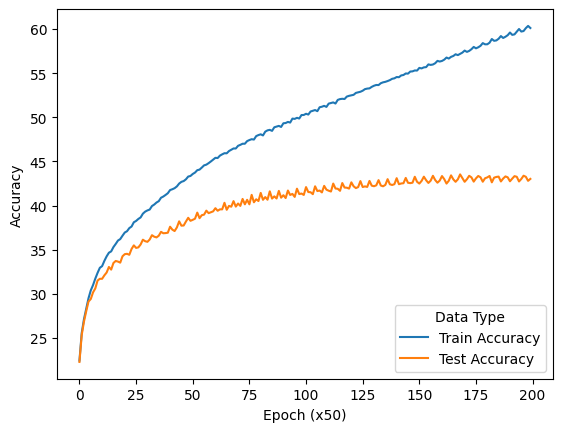

In [ ]:
#Print results for the L2 Model.
plotLossAndAcc(L2Model)

Task 3-4: Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this time,
train it with unnormalized images.

In [ ]:
#Define and train the Not-Normalized model.
UnnormalizedModel = MLP(["Relu", "Relu"], [256, 256], 0.00008, norm=True) #LR 0.00001 gave 37.51%-36% acc. LR 0.00005 gave 49.058%-39.51%
UnnormalizedModel.fit(np.asarray(trainX), trainY, 10000, np.asarray(testX), testY) 

100%|██████████| 10000/10000 [06:17<00:00, 26.47it/s]


LOSS


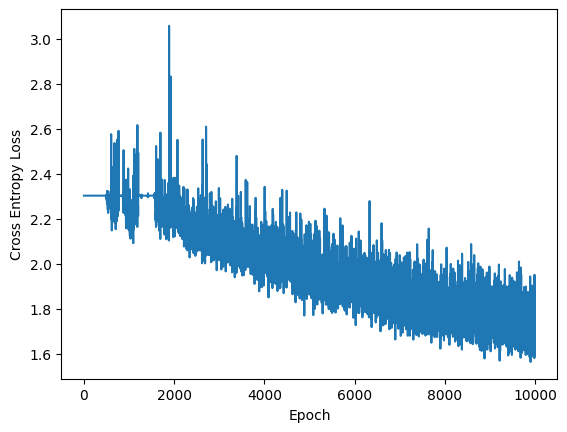

Final train accuracy:  36.036 %
Final test accuracy:  32.769999999999996 %


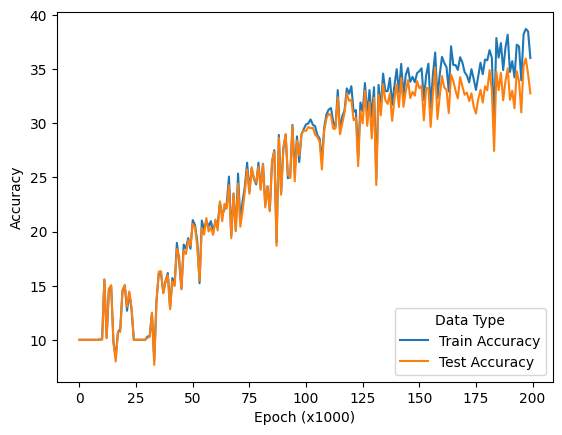

In [ ]:
#Print its results.
plotLossAndAcc(UnnormalizedModel, accInterval="1000")

Task 3-5 (We'll be using TensorFlow, see https://www.tensorflow.org/tutorials/images/cnn and https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data)

In [19]:
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dropout

(train_images, train_labels), (test_images, test_labels) = k.datasets.cifar10.load_data()
# Normalize pixel values
train_images_norm, test_images_norm = train_images / 255.0, test_images / 255.0

trainX_reshaped = np.reshape(trainX_processed, (50000, 32, 32, 1))
testX_reshaped = np.reshape(testX_processed, (10000, 32, 32, 1))

170498071/170498071 [==============================] - 4s 0us/step


Without Pooling (Take care! 'CNNWithPooling' not labelled correctly)

In [20]:
# Without Pooling
# Create a convolutional model base. Takes in (image_height, image_width, color_channels) for input shape.
CNNWithPooling = Sequential()
CNNWithPooling.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
CNNWithPooling.add(Conv2D(32, (3, 3), activation='relu')) 

CNNWithPooling.add(Flatten())
CNNWithPooling.add(Dense(units=256, activation='relu')) # Define the two fully-connected layers
CNNWithPooling.add(Dense(units=256, activation='relu'))
CNNWithPooling.add(Dense(units=10, activation='softmax')) # Output 10 classes, softmax for categorial classification

# Compile the model.
CNNWithPooling.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

history_noMaxPooling = CNNWithPooling.fit(trainX_reshaped, trainY, epochs=10, batch_size = 32, validation_data=(testX_reshaped, test_labels))


Epoch 1/10
1563/1563 [==============================] - 319s 203ms/step - loss: 1.3517 - accuracy: 0.5207 - val_loss: 1.0776 - val_accuracy: 0.6202
Epoch 2/10
1563/1563 [==============================] - 301s 193ms/step - loss: 0.8565 - accuracy: 0.7020 - val_loss: 1.0714 - val_accuracy: 0.6329
Epoch 3/10
1563/1563 [==============================] - 363s 232ms/step - loss: 0.4861 - accuracy: 0.8331 - val_loss: 1.1978 - val_accuracy: 0.6363
Epoch 4/10
1563/1563 [==============================] - 415s 266ms/step - loss: 0.2100 - accuracy: 0.9289 - val_loss: 1.5406 - val_accuracy: 0.6266
Epoch 5/10
1563/1563 [==============================] - 328s 210ms/step - loss: 0.1105 - accuracy: 0.9630 - val_loss: 1.8957 - val_accuracy: 0.6221
Epoch 6/10
1563/1563 [==============================] - 285s 182ms/step - loss: 0.0859 - accuracy: 0.9719 - val_loss: 2.3415 - val_accuracy: 0.6197
Epoch 7/10
1563/1563 [==============================] - 292s 187ms/step - loss: 0.0690 - accuracy: 0.9768 - val_

With Pooling

In [21]:
CNNNoPooling = Sequential()
CNNNoPooling.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1))) # Define Convolutional Layer 1
CNNNoPooling.add(MaxPooling2D((2, 2)))
CNNNoPooling.add(Conv2D(16, (3, 3), activation='relu')) # Define Convolutional Layer 2Tfmodel.add(MaxPooling2D((2, 2)))
CNNNoPooling.add(MaxPooling2D((2, 2)))

CNNNoPooling.add(Flatten())
CNNNoPooling.add(Dense(units=256, activation='relu')) # Define the two fully-connected layers
CNNNoPooling.add(Dense(units=256, activation='relu'))
CNNNoPooling.add(Dense(units=10, activation='softmax')) # Output 10 classes, softmax for categorial classification

# Compile the model.
CNNNoPooling.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

history_MaxPooling = CNNNoPooling.fit(trainX_reshaped, trainY, epochs=10, batch_size = 32, validation_data=(testX_reshaped, test_labels))

Epoch 1/10
1563/1563 [==============================] - 70s 44ms/step - loss: 1.4765 - accuracy: 0.4740 - val_loss: 1.2025 - val_accuracy: 0.5746
Epoch 2/10
1563/1563 [==============================] - 68s 43ms/step - loss: 1.0950 - accuracy: 0.6185 - val_loss: 1.0494 - val_accuracy: 0.6345
Epoch 3/10
1563/1563 [==============================] - 64s 41ms/step - loss: 0.9267 - accuracy: 0.6801 - val_loss: 1.0179 - val_accuracy: 0.6494
Epoch 4/10
1563/1563 [==============================] - 64s 41ms/step - loss: 0.8070 - accuracy: 0.7189 - val_loss: 0.9526 - val_accuracy: 0.6753
Epoch 5/10
1563/1563 [==============================] - 67s 43ms/step - loss: 0.7042 - accuracy: 0.7542 - val_loss: 0.9723 - val_accuracy: 0.6743
Epoch 6/10
1563/1563 [==============================] - 66s 42ms/step - loss: 0.6154 - accuracy: 0.7847 - val_loss: 0.9802 - val_accuracy: 0.6832
Epoch 7/10
1563/1563 [==============================] - 72s 46ms/step - loss: 0.5290 - accuracy: 0.8157 - val_loss: 1.0445 -

Change Batch Size 

In [22]:
CNNBatch128 = Sequential()
CNNBatch128.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1))) # Define Convolutional Layer 1
CNNBatch128.add(MaxPooling2D((2, 2)))
CNNBatch128.add(Conv2D(16, (3, 3), activation='relu')) # Define Convolutional Layer 2Tfmodel.add(MaxPooling2D((2, 2)))
CNNBatch128.add(MaxPooling2D((2, 2)))

CNNBatch128.add(Flatten())
CNNBatch128.add(Dense(units=256, activation='relu')) # Define the two fully-connected layers
CNNBatch128.add(Dense(units=256, activation='relu'))
CNNBatch128.add(Dense(units=10, activation='softmax')) # Output 10 classes, softmax for categorial classification

# Compile the model.
CNNBatch128.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

history_CNNBatch128 = CNNBatch128.fit(trainX_reshaped, trainY, epochs=10,  batch_size=128, validation_data=(testX_reshaped, test_labels))

Epoch 1/10
391/391 [==============================] - 52s 131ms/step - loss: 1.6441 - accuracy: 0.4127 - val_loss: 1.3649 - val_accuracy: 0.5212
Epoch 2/10
391/391 [==============================] - 54s 139ms/step - loss: 1.2600 - accuracy: 0.5589 - val_loss: 1.1968 - val_accuracy: 0.5796
Epoch 3/10
391/391 [==============================] - 53s 134ms/step - loss: 1.0919 - accuracy: 0.6205 - val_loss: 1.0729 - val_accuracy: 0.6223
Epoch 4/10
391/391 [==============================] - 52s 134ms/step - loss: 0.9661 - accuracy: 0.6635 - val_loss: 1.0105 - val_accuracy: 0.6452
Epoch 5/10
391/391 [==============================] - 51s 130ms/step - loss: 0.8723 - accuracy: 0.6974 - val_loss: 0.9631 - val_accuracy: 0.6647
Epoch 6/10
391/391 [==============================] - 56s 144ms/step - loss: 0.7903 - accuracy: 0.7260 - val_loss: 0.9628 - val_accuracy: 0.6681
Epoch 7/10
391/391 [==============================] - 51s 131ms/step - loss: 0.7240 - accuracy: 0.7496 - val_loss: 0.9100 - val_ac

In [28]:
CNNBatch256 = Sequential()
CNNBatch256.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1))) # Define Convolutional Layer 1
CNNBatch256.add(MaxPooling2D((2, 2)))
CNNBatch256.add(Conv2D(16, (3, 3), activation='relu')) # Define Convolutional Layer 2Tfmodel.add(MaxPooling2D((2, 2)))
CNNBatch256.add(MaxPooling2D((2, 2)))

CNNBatch256.add(Flatten())
CNNBatch256.add(Dense(units=256, activation='relu')) # Define the two fully-connected layers
CNNBatch256.add(Dense(units=256, activation='relu'))
CNNBatch256.add(Dense(units=10, activation='softmax')) # Output 10 classes, softmax for categorial classification

# Compile the model.
CNNBatch256.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

history_CNNBatch256 = CNNBatch256.fit(trainX_reshaped, trainY, epochs=10,  batch_size=256, validation_data=(testX_reshaped, test_labels))

Epoch 1/10
196/196 [==============================] - 53s 259ms/step - loss: 1.7341 - accuracy: 0.3826 - val_loss: 1.4905 - val_accuracy: 0.4800
Epoch 2/10
196/196 [==============================] - 48s 244ms/step - loss: 1.3836 - accuracy: 0.5158 - val_loss: 1.3069 - val_accuracy: 0.5425
Epoch 3/10
196/196 [==============================] - 52s 265ms/step - loss: 1.2287 - accuracy: 0.5710 - val_loss: 1.1971 - val_accuracy: 0.5819
Epoch 4/10
196/196 [==============================] - 49s 251ms/step - loss: 1.1193 - accuracy: 0.6121 - val_loss: 1.1546 - val_accuracy: 0.5974
Epoch 5/10
196/196 [==============================] - 51s 263ms/step - loss: 1.0410 - accuracy: 0.6390 - val_loss: 1.0721 - val_accuracy: 0.6277
Epoch 6/10
196/196 [==============================] - 50s 253ms/step - loss: 0.9694 - accuracy: 0.6671 - val_loss: 1.0493 - val_accuracy: 0.6357
Epoch 7/10
196/196 [==============================] - 48s 248ms/step - loss: 0.9059 - accuracy: 0.6874 - val_loss: 1.0256 - val_ac

Varying Kernel Size No Padding

In [31]:
# Kernel Size 5x5
CNNFilter5 = Sequential()
CNNFilter5.add(Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 1)))
CNNFilter5.add(MaxPooling2D((2, 2)))
CNNFilter5.add(Conv2D(32, (5, 5), activation='relu')) 
CNNFilter5.add(MaxPooling2D((2, 2)))

CNNFilter5.add(Flatten())
CNNFilter5.add(Dense(units=256, activation='relu')) # Define the two fully-connected layers
CNNFilter5.add(Dense(units=256, activation='relu'))
CNNFilter5.add(Dense(units=10, activation='softmax')) # Output 10 classes, softmax for categorial classification

# Compile the model.
CNNFilter5.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

history_CNNFilter5 = CNNFilter5.fit(trainX_reshaped, trainY, epochs=10, batch_size = 32, validation_data=(testX_reshaped, test_labels))

Epoch 1/10
1563/1563 [==============================] - 94s 59ms/step - loss: 1.4762 - accuracy: 0.4750 - val_loss: 1.1921 - val_accuracy: 0.5754
Epoch 2/10
1563/1563 [==============================] - 96s 61ms/step - loss: 1.0837 - accuracy: 0.6201 - val_loss: 1.0455 - val_accuracy: 0.6399
Epoch 3/10
1563/1563 [==============================] - 93s 60ms/step - loss: 0.9143 - accuracy: 0.6811 - val_loss: 0.9427 - val_accuracy: 0.6780
Epoch 4/10
1563/1563 [==============================] - 92s 59ms/step - loss: 0.7972 - accuracy: 0.7222 - val_loss: 0.9520 - val_accuracy: 0.6757
Epoch 5/10
1563/1563 [==============================] - 91s 58ms/step - loss: 0.6981 - accuracy: 0.7548 - val_loss: 0.9661 - val_accuracy: 0.6791
Epoch 6/10
1563/1563 [==============================] - 93s 60ms/step - loss: 0.6135 - accuracy: 0.7841 - val_loss: 1.0019 - val_accuracy: 0.6748
Epoch 7/10
1563/1563 [==============================] - 89s 57ms/step - loss: 0.5226 - accuracy: 0.8144 - val_loss: 1.0417 -

In [32]:
# Kernel Size 7x7
CNNFilter7 = Sequential()
CNNFilter7.add(Conv2D(32, (7, 7), activation='relu', input_shape=(32, 32, 1)))
CNNFilter7.add(MaxPooling2D((2, 2)))
CNNFilter7.add(Conv2D(32, (7, 7), activation='relu')) 
CNNFilter7.add(MaxPooling2D((2, 2)))

CNNFilter7.add(Flatten())
CNNFilter7.add(Dense(units=256, activation='relu')) # Define the two fully-connected layers
CNNFilter7.add(Dense(units=256, activation='relu'))
CNNFilter7.add(Dense(units=10, activation='softmax')) # Output 10 classes, softmax for categorial classification

# Compile the model.
CNNFilter7.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

history_CNNFilter7 = CNNFilter7.fit(trainX_reshaped, trainY, epochs=10, batch_size = 32, validation_data=(testX_reshaped, test_labels))

Epoch 1/10
1563/1563 [==============================] - 94s 59ms/step - loss: 1.6115 - accuracy: 0.4186 - val_loss: 1.4142 - val_accuracy: 0.4914
Epoch 2/10
1563/1563 [==============================] - 91s 58ms/step - loss: 1.2846 - accuracy: 0.5453 - val_loss: 1.2621 - val_accuracy: 0.5520
Epoch 3/10
1563/1563 [==============================] - 97s 62ms/step - loss: 1.1290 - accuracy: 0.6012 - val_loss: 1.1642 - val_accuracy: 0.5894
Epoch 4/10
1563/1563 [==============================] - 91s 58ms/step - loss: 1.0305 - accuracy: 0.6377 - val_loss: 1.1043 - val_accuracy: 0.6139
Epoch 5/10
1563/1563 [==============================] - 93s 59ms/step - loss: 0.9480 - accuracy: 0.6676 - val_loss: 1.0912 - val_accuracy: 0.6236
Epoch 6/10
1563/1563 [==============================] - 90s 58ms/step - loss: 0.8788 - accuracy: 0.6923 - val_loss: 1.1010 - val_accuracy: 0.6204
Epoch 7/10
1563/1563 [==============================] - 92s 59ms/step - loss: 0.8111 - accuracy: 0.7130 - val_loss: 1.1076 -

Adding Dropout with Pooling 

In [33]:
CNNDrop1_Pool = Sequential()
CNNDrop1_Pool.add(Dropout(0.2, input_shape=(32, 32, 1)))
CNNDrop1_Pool.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
CNNDrop1_Pool.add(MaxPooling2D((2, 2)))
CNNDrop1_Pool.add(Conv2D(16, (3, 3), activation='relu')) 
CNNDrop1_Pool.add(MaxPooling2D((2, 2)))

CNNDrop1_Pool.add(Flatten())
CNNDrop1_Pool.add(Dense(units=256, activation='relu')) # Define the two fully-connected layers
CNNDrop1_Pool.add(Dense(units=256, activation='relu'))
CNNDrop1_Pool.add(Dense(units=10, activation='softmax')) # Output 10 classes, softmax for categorial classification

# Compile the model.
CNNDrop1_Pool.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

history_CNNDrop1_Pool = CNNDrop1_Pool.fit(trainX_reshaped, trainY, epochs=10, batch_size = 32, validation_data=(testX_reshaped, test_labels))

Epoch 1/10
1563/1563 [==============================] - 65s 41ms/step - loss: 1.6119 - accuracy: 0.4236 - val_loss: 1.4501 - val_accuracy: 0.4868
Epoch 2/10
1563/1563 [==============================] - 66s 42ms/step - loss: 1.3107 - accuracy: 0.5380 - val_loss: 1.4289 - val_accuracy: 0.5056
Epoch 3/10
1563/1563 [==============================] - 66s 42ms/step - loss: 1.1758 - accuracy: 0.5901 - val_loss: 1.3968 - val_accuracy: 0.5158
Epoch 4/10
1563/1563 [==============================] - 66s 42ms/step - loss: 1.0683 - accuracy: 0.6284 - val_loss: 1.2815 - val_accuracy: 0.5598
Epoch 5/10
1563/1563 [==============================] - 66s 42ms/step - loss: 0.9829 - accuracy: 0.6568 - val_loss: 1.3343 - val_accuracy: 0.5535
Epoch 6/10
1563/1563 [==============================] - 65s 41ms/step - loss: 0.9073 - accuracy: 0.6827 - val_loss: 1.2735 - val_accuracy: 0.5720
Epoch 7/10
1563/1563 [==============================] - 68s 43ms/step - loss: 0.8409 - accuracy: 0.7043 - val_loss: 1.3110 -

In [40]:
CNNDrop2_Pool = Sequential()
CNNDrop2_Pool.add(Dropout(0.5, input_shape=(32, 32, 1)))
CNNDrop2_Pool.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
CNNDrop2_Pool.add(MaxPooling2D((2, 2)))
CNNDrop2_Pool.add(Conv2D(16, (3, 3), activation='relu')) 
CNNDrop2_Pool.add(MaxPooling2D((2, 2)))

CNNDrop2_Pool.add(Flatten())
CNNDrop2_Pool.add(Dense(units=256, activation='relu')) # Define the two fully-connected layers
CNNDrop2_Pool.add(Dense(units=256, activation='relu'))
CNNDrop2_Pool.add(Dense(units=10, activation='softmax')) # Output 10 classes, softmax for categorial classification

# Compile the model.
CNNDrop2_Pool.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

history_CNNDrop2_Pool = CNNDrop2_Pool.fit(trainX_reshaped, trainY, epochs=10,  batch_size = 32, validation_data=(testX_reshaped, test_labels))

Epoch 1/10
1563/1563 [==============================] - 68s 43ms/step - loss: 1.7272 - accuracy: 0.3791 - val_loss: 2.7562 - val_accuracy: 0.2411
Epoch 2/10
1563/1563 [==============================] - 64s 41ms/step - loss: 1.4765 - accuracy: 0.4789 - val_loss: 2.7326 - val_accuracy: 0.2697
Epoch 3/10
1563/1563 [==============================] - 67s 43ms/step - loss: 1.3399 - accuracy: 0.5277 - val_loss: 3.4601 - val_accuracy: 0.2322
Epoch 4/10
1563/1563 [==============================] - 65s 41ms/step - loss: 1.2404 - accuracy: 0.5651 - val_loss: 2.9365 - val_accuracy: 0.2666
Epoch 5/10
1563/1563 [==============================] - 66s 42ms/step - loss: 1.1582 - accuracy: 0.5965 - val_loss: 3.0026 - val_accuracy: 0.2628
Epoch 6/10
1563/1563 [==============================] - 68s 44ms/step - loss: 1.0879 - accuracy: 0.6189 - val_loss: 3.2738 - val_accuracy: 0.2656
Epoch 7/10
1563/1563 [==============================] - 66s 42ms/step - loss: 1.0236 - accuracy: 0.6416 - val_loss: 3.3009 -

In [35]:
CNNDrop3_Pool = Sequential()
CNNDrop3_Pool.add(Dropout(0.9, input_shape=(32, 32, 1)))
CNNDrop3_Pool.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
CNNDrop3_Pool.add(MaxPooling2D((2, 2)))
CNNDrop3_Pool.add(Conv2D(16, (3, 3), activation='relu')) 
CNNDrop3_Pool.add(MaxPooling2D((2, 2)))

CNNDrop3_Pool.add(Flatten())
CNNDrop3_Pool.add(Dense(units=256, activation='relu')) # Define the two fully-connected layers
CNNDrop3_Pool.add(Dense(units=256, activation='relu'))
CNNDrop3_Pool.add(Dense(units=10, activation='softmax')) # Output 10 classes, softmax for categorial classification

# Compile the model.
CNNDrop3_Pool.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

history_CNNDrop3_Pool = CNNDrop3_Pool.fit(trainX_reshaped, trainY, epochs=10, batch_size = 32, validation_data=(testX_reshaped, test_labels))

Epoch 1/10
1563/1563 [==============================] - 68s 42ms/step - loss: 1.9414 - accuracy: 0.3016 - val_loss: 2.8831 - val_accuracy: 0.1255
Epoch 2/10
1563/1563 [==============================] - 63s 40ms/step - loss: 1.7819 - accuracy: 0.3648 - val_loss: 3.0532 - val_accuracy: 0.1616
Epoch 3/10
1563/1563 [==============================] - 67s 43ms/step - loss: 1.7191 - accuracy: 0.3861 - val_loss: 3.3021 - val_accuracy: 0.1817
Epoch 4/10
1563/1563 [==============================] - 63s 40ms/step - loss: 1.6891 - accuracy: 0.3997 - val_loss: 3.3550 - val_accuracy: 0.1769
Epoch 5/10
1563/1563 [==============================] - 65s 41ms/step - loss: 1.6608 - accuracy: 0.4104 - val_loss: 3.3281 - val_accuracy: 0.1902
Epoch 6/10
1563/1563 [==============================] - 67s 43ms/step - loss: 1.6354 - accuracy: 0.4189 - val_loss: 3.2061 - val_accuracy: 0.1868
Epoch 7/10
1563/1563 [==============================] - 62s 40ms/step - loss: 1.6183 - accuracy: 0.4271 - val_loss: 3.2274 -

Task 3-6:  Load a pre-trained model that you see fit (e.g., a ResNet) using existing libraries such as TensorFlow or PyTorch,
and then freeze all the convolutional layers and remove all the fully connected ones. Add a number of fully
connected layers of your choice right after the convolutional layers. Train only the fully connected layers of the
pre-trained model on the CIFAR-10 dataset. How does this pre-trained model compare to the best MLP in part
1 and to the regular CNN in part 5 in terms of the accuracy?

Ref: https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b

In [ ]:
def ResNetPreprocess(X,Y): #This
  X_Processed = k.applications.resnet50.preprocess_input(X)
  Y_Processed = k.utils.to_categorical(Y,10)
  return X_Processed, Y_Processed


(x_train, y_train), (x_test, y_test) = k.datasets.cifar10.load_data()
x_train, y_train = ResNetPreprocess(x_train, y_train)
x_test, y_test = ResNetPreprocess(x_test, y_test)
input_tens = k.Input(shape=(32,32,3))
resnet = k.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=input_tens) #Include_top being false removes the dense/fully connected layers

# Freeze Resnet layers
for layer in resnet.layers:
  layer.trainable = False

# Uncomment this to check the Resnet layers. 
#for i, layer in enumerate(resnet.layers):
#   print(i, layer.name, "-", layer.trainable)

# Create the model
PreTrainedModel = k.models.Sequential()
PreTrainedModel.add(resnet)
PreTrainedModel.add(k.layers.Flatten())

#Here we can add our fully-connected layer(s). We can tweak the number of fully connected layers, and how many units each one should have.
PreTrainedModel.add(k.layers.Dense(units=256, activation='relu'))
PreTrainedModel.add(k.layers.Dense(units=256, activation='relu'))
PreTrainedModel.add(k.layers.Dense(units=256, activation='relu'))
#PreTrainedModel.add(k.layers.Dense(units=128, activation='relu'))
#PreTrainedModel.add(k.layers.Dense(units=64, activation='relu'))
#PreTrainedModel.add(k.layers.Dense(units=32, activation='relu'))
#PreTrainedModel.add(k.layers.Dense(units=16, activation='relu'))


# Way to check that 
#for i, layer in enumerate(model.layers):
#   print(i, layer.name, "-", layer.trainable)

#Add the final softmax layer.
PreTrainedModel.add(k.layers.Dense(10, activation='softmax'))

#Compile and run
opt = tf.keras.optimizers.RMSprop(learning_rate=2e-5)
#model.compile(optimizer=opt,
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])
PreTrainedModel.compile(optimizer=opt,
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history_pretrained_test = PreTrainedModel.fit(trainX_RGB_processed, y_train, batch_size=32, epochs=10, 
                    validation_data=(testX_RGB_processed,y_test))

#Plot the model's results and print the final accuracy.
plt.plot(history_pretrained_test.history['accuracy'], label='accuracy')
plt.plot(history_pretrained_test.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')
test_loss, test_acc = PreTrainedModel.evaluate(testX_RGB_processed, y_test, verbose=2)
print(test_acc);

In [ ]:
trainx_norm_reshape = np.reshape(trainX_processed, (50000, 32, 32))
testx_norm_reshape = np.reshape(testX_processed, (10000, 32, 32))
trainX_norm_3dim = np.repeat(trainx_norm_reshape[..., np.newaxis], 3, -1)
testX_norm_3dim =  np.repeat(testx_norm_reshape[..., np.newaxis], 3, -1)
print(np.shape(trainX_norm_3dim))
print(np.shape(testX_norm_3dim))

In [ ]:
def ResNetPreprocess(X,Y): #or This
  X_Processed = k.applications.resnet50.preprocess_input(X)
  Y_Processed = k.utils.to_categorical(Y,10)
  return X_Processed, Y_Processed


(x_train, y_train), (x_test, y_test) = k.datasets.cifar10.load_data()
x_train, y_train = ResNetPreprocess(x_train, y_train)
x_test, y_test = ResNetPreprocess(x_test, y_test)

input_tens = k.Input(shape=(32,32, 3))
resnet = k.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=input_tens) #Include_top being false removes the dense/fully connected layers

# Freeze Resnet layers
for layer in resnet.layers:
  layer.trainable = False

# Uncomment this to check the Resnet layers. 
#for i, layer in enumerate(resnet.layers):
#   print(i, layer.name, "-", layer.trainable)

# Create the model
model = k.models.Sequential()
model.add(resnet)
model.add(k.layers.Flatten())

model.add(k.layers.Dense(units=256, activation='relu'))
model.add(k.layers.Dense(units=256, activation='relu'))

# Way to check that 
#for i, layer in enumerate(model.layers):
#   print(i, layer.name, "-", layer.trainable)

#Add the final softmax layer.
model.add(k.layers.Dense(10, activation='softmax'))

#Compile and run
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history_pretrained_test = model.fit(trainX_norm_3dim, y_train, batch_size=128, epochs=10, 
                    validation_data=(testX_norm_3dim, y_test))

In [ ]:
def ResNetPreprocess(X,Y):
  X_Processed = k.applications.resnet50.preprocess_input(X)
  Y_Processed = k.utils.to_categorical(Y,10)
  return X_Processed, Y_Processed


(x_train, y_train), (x_test, y_test) = k.datasets.cifar10.load_data()
x_train, y_train = ResNetPreprocess(x_train, y_train)
x_test, y_test = ResNetPreprocess(x_test, y_test)

input_tens = k.Input(shape=(32,32, 3))
resnet = k.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=input_tens) #Include_top being false removes the dense/fully connected layers

# Freeze Resnet layers
for layer in resnet.layers:
  layer.trainable = False

# Uncomment this to check the Resnet layers. 
#for i, layer in enumerate(resnet.layers):
#   print(i, layer.name, "-", layer.trainable)

# Create the model
model = k.models.Sequential()
model.add(resnet)
model.add(k.layers.Flatten())

model.add(k.layers.Dense(units=128, activation='relu'))
model.add(k.layers.Dense(units=128, activation='relu'))

# Way to check that 
#for i, layer in enumerate(model.layers):
#   print(i, layer.name, "-", layer.trainable)

#Add the final softmax layer.
model.add(k.layers.Dense(10, activation='softmax'))

#Compile and run
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history_pretrained_test = model.fit(trainX_norm_3dim, y_train, batch_size=128, epochs=10, 
                    validation_data=(testX_norm_3dim, y_test))

Now we plot our results

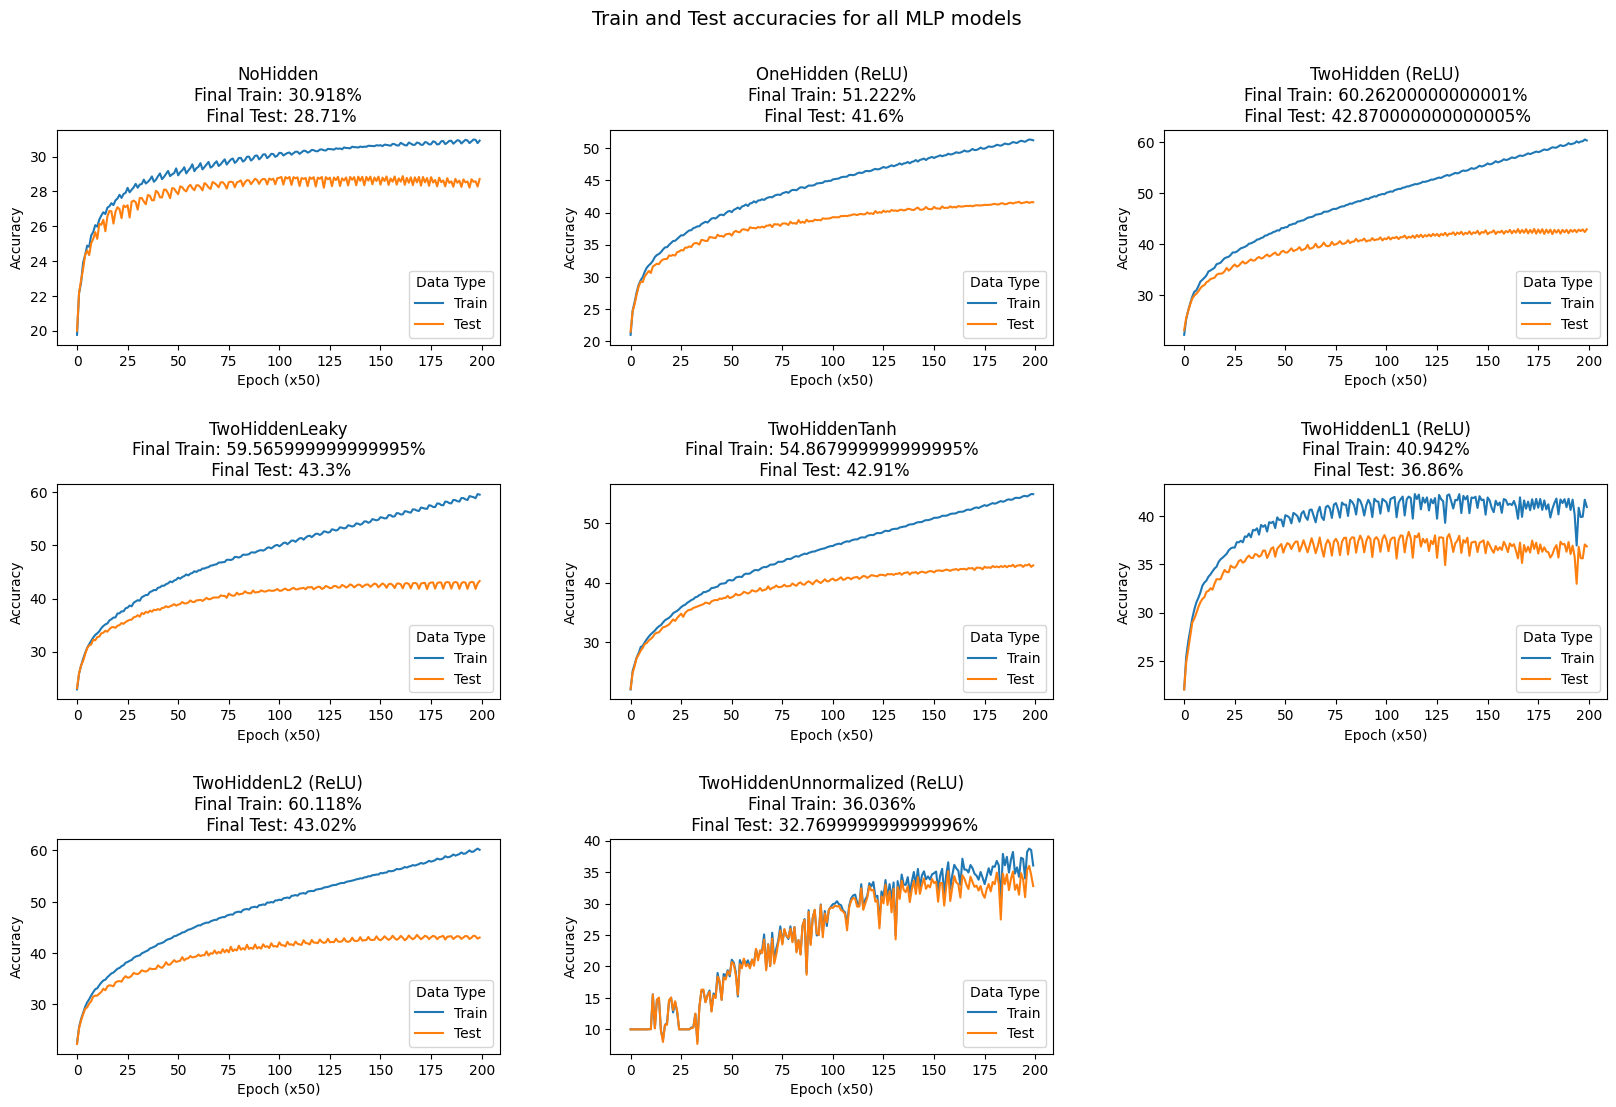

In [ ]:
#Plot 3x3 MLP grid 
fig, axes = plt.subplots(ncols=3, nrows=3, sharex=False, sharey=False, figsize=(20, 12))
x = 0
y = 0
models=[NoHiddenModel, OneHiddenModel, TwoHiddenModel, LeakyModel, TanhModel, L1Model, L2Model, UnnormalizedModel]
model_names = ["NoHidden", "OneHidden (ReLU)", "TwoHidden (ReLU)", "TwoHiddenLeaky", "TwoHiddenTanh", "TwoHiddenL1 (ReLU)", "TwoHiddenL2 (ReLU)", "TwoHiddenUnnormalized (ReLU)"]


fig.suptitle('Train and Test accuracies for all MLP models', y=0.98, fontsize=14)
for i in range(0,8):
    x=int(i/3)
    y=i%3

    axes[x][y].plot(models[i].accuracy_array, label="Train")
    axes[x][y].plot(models[i].accuracy_array_test, label="Test")
    axes[x][y].set_title(model_names[i]+ "\nFinal Train: " + str(models[i].accuracy_array[-1]) + "%\n Final Test: " + str(models[i].accuracy_array_test[-1]) + "%"  )
    axes[x][y].set(xlabel="Epoch (x50)", ylabel='Accuracy')
    axes[x][y].legend(loc="lower right", title="Data Type")
    
plt.subplots_adjust(wspace=0.25, hspace=0.65)
axes[2,2].set_visible(False)
plt.show()

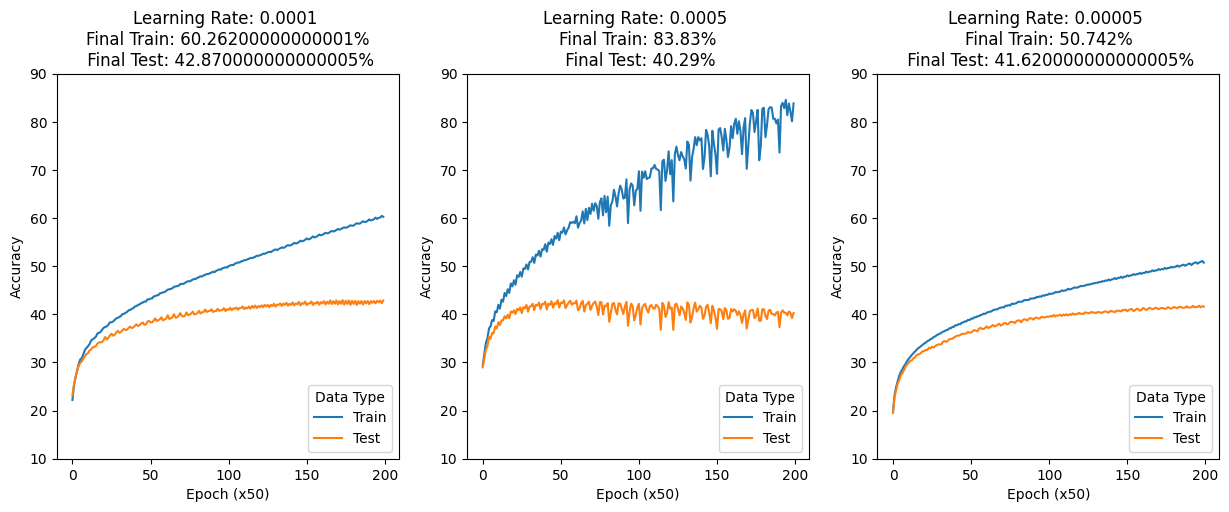

In [ ]:
#Plot MLP wrt. learning rate for TwoHidden 
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15 ,5))
axes[0].plot(TwoHiddenModel.accuracy_array, label="Train")
axes[0].plot(TwoHiddenModel.accuracy_array_test, label="Test") 
axes[0].set_title("Learning Rate: 0.0001 \nFinal Train: " + str(TwoHiddenModel.accuracy_array[-1]) + "%\n Final Test: " + str(TwoHiddenModel.accuracy_array_test[-1]) + "%"  )
axes[0].set(xlabel="Epoch (x50)", ylabel='Accuracy')
axes[0].legend(loc="lower right", title="Data Type")
axes[0].set_ylim([10, 90])

axes[1].plot(TwoHiddenModel0_0005.accuracy_array, label="Train")
axes[1].plot(TwoHiddenModel0_0005.accuracy_array_test, label="Test") 
axes[1].set_title("Learning Rate: 0.0005 \nFinal Train: " + str(TwoHiddenModel0_0005.accuracy_array[-1]) + "%\n Final Test: " + str(TwoHiddenModel0_0005.accuracy_array_test[-1]) + "%"  )
axes[1].set(xlabel="Epoch (x50)", ylabel='Accuracy')
axes[1].legend(loc="lower right", title="Data Type")
axes[1].set_ylim([10, 90])

axes[2].plot(TwoHiddenModel0_00005.accuracy_array, label="Train")
axes[2].plot(TwoHiddenModel0_00005.accuracy_array_test, label="Test") 
axes[2].set_title("Learning Rate: 0.00005 \nFinal Train: " + str(TwoHiddenModel0_00005.accuracy_array[-1]) + "%\n Final Test: " + str(TwoHiddenModel0_00005.accuracy_array_test[-1]) + "%"  )
axes[2].set(xlabel="Epoch (x50)", ylabel='Accuracy')
axes[2].legend(loc="lower right", title="Data Type")
axes[2].set_ylim([10, 90])

plt.show()

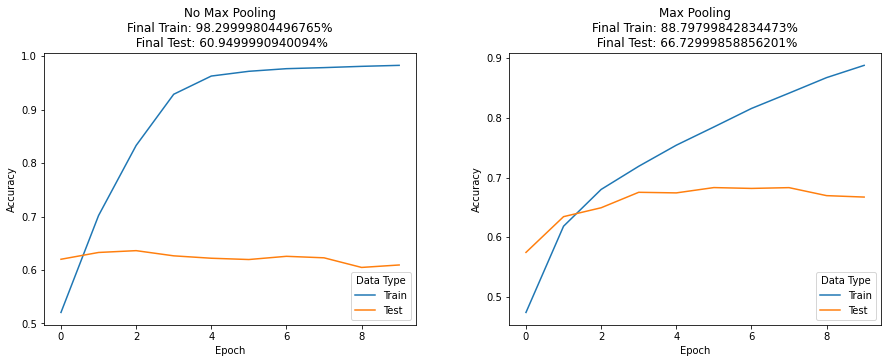

In [41]:
def PlotCNN(CNN1, CNN2, title1, title2):
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
  axes[0].plot(CNN1.history['accuracy'], label='Train')
  axes[0].plot(CNN1.history['val_accuracy'], label = 'Test')
  axes[0].set_title(title1 + "\nFinal Train: " + str(CNN1.history['accuracy'][-1] * 100) + "%\n Final Test: " + str(CNN1.history['val_accuracy'][-1] * 100) + "%"  )
  axes[0].set(xlabel="Epoch", ylabel='Accuracy')
  axes[0].legend(loc="lower right", title="Data Type")

  axes[1].plot(CNN2.history['accuracy'], label='Train')
  axes[1].plot(CNN2.history['val_accuracy'], label = 'Test')
  axes[1].set_title(title2 + "\nFinal Train: " + str(CNN2.history['accuracy'][-1] * 100) + "%\n Final Test: " + str(CNN2.history['val_accuracy'][-1] * 100) + "%"  )
  axes[1].set(xlabel="Epoch", ylabel='Accuracy')
  axes[1].legend(loc="lower right", title="Data Type")

  plt.subplots_adjust(wspace=0.25, hspace=0.65)
  plt.show()

def Plot3CNN(CNN1, CNN2, CNN3, title1, title2, title3):
  fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
  axes[0].plot(CNN1.history['accuracy'], label='Train')
  axes[0].plot(CNN1.history['val_accuracy'], label = 'Test')
  axes[0].set_title(title1 + "\nFinal Train: " + str(CNN1.history['accuracy'][-1] * 100) + "%\n Final Test: " + str(CNN1.history['val_accuracy'][-1] * 100) + "%"  )
  axes[0].set(xlabel="Epoch", ylabel='Accuracy')
  axes[0].legend(loc="lower right", title="Data Type")

  axes[1].plot(CNN2.history['accuracy'], label='Train')
  axes[1].plot(CNN2.history['val_accuracy'], label = 'Test')
  axes[1].set_title(title2 + "\nFinal Train: " + str(CNN2.history['accuracy'][-1] * 100) + "%\n Final Test: " + str(CNN2.history['val_accuracy'][-1] * 100) + "%"  )
  axes[1].set(xlabel="Epoch", ylabel='Accuracy')
  axes[1].legend(loc="lower right", title="Data Type")

  axes[2].plot(CNN3.history['accuracy'], label='Train')
  axes[2].plot(CNN3.history['val_accuracy'], label = 'Test')
  axes[2].set_title(title3 + "\nFinal Train: " + str(CNN3.history['accuracy'][-1] * 100) + "%\n Final Test: " + str(CNN3.history['val_accuracy'][-1] * 100) + "%"  )
  axes[2].set(xlabel="Epoch", ylabel='Accuracy')
  axes[2].legend(loc="lower right", title="Data Type")

  plt.subplots_adjust(wspace=0.25, hspace=0.65)
  plt.show()

#Plot CNN with MaxPooling and Without
PlotCNN(history_noMaxPooling, history_MaxPooling, "No Max Pooling", "Max Pooling")

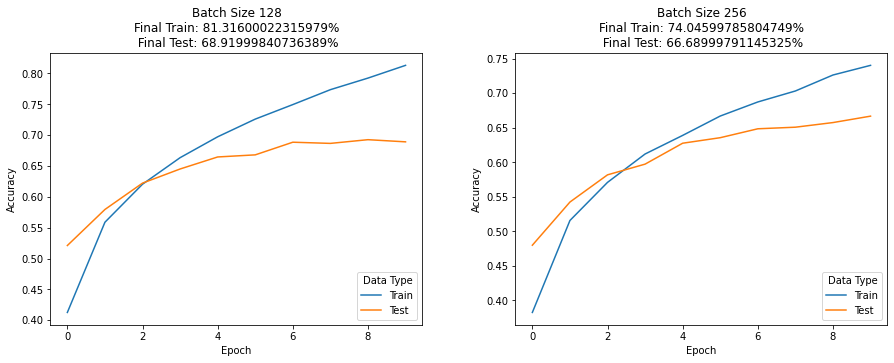

In [36]:
#Plot CNN with different batches  
PlotCNN(history_CNNBatch128, history_CNNBatch256, "Batch Size 128", "Batch Size 256")

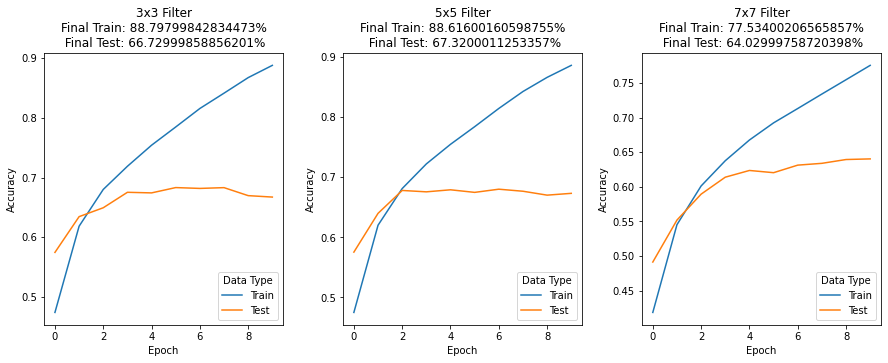

In [44]:
#Plot CNN with different filters
Plot3CNN(history_MaxPooling, history_CNNFilter5, history_CNNFilter7, "3x3 Filter", "5x5 Filter", "7x7 Filter")

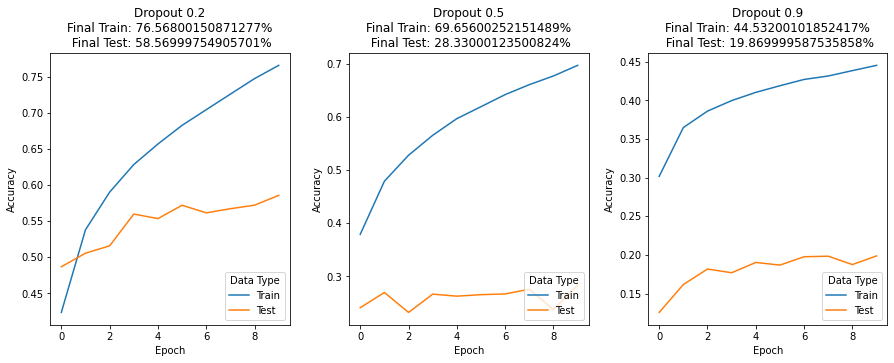

In [45]:
#Plot CNN with different dropout
Plot3CNN(history_CNNDrop1_Pool, history_CNNDrop2_Pool, history_CNNDrop3_Pool, "Dropout 0.2", "Dropout 0.5", "Dropout 0.9")